In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from spectral import *
import numpy as np
import scipy.spatial.distance as distance
import pylab
import spectral.io.envi as envi
import random
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from timeit import default_timer as timer

In [4]:
from autoclustering import find_maxdist_clusters
from hiersubclustering import subdivide_by_modules
from visual_utils import show_classes, show_histogram, show_centers
from math_utils import cluster_histogram, normalized

Читаем изображение.

In [5]:
#img = open_image('92AV3C.lan')
# gt = open_image('92AV3GT.GIS').read_band(0)
img = envi.open('f080611t01p00r07rdn_c_sc01_ort_img.hdr')

In [6]:
print(img)

	Data Source:   '/home/marko/HSI/f080611t01p00r07rdn_c/f080611t01p00r07rdn_c_sc01_ort_img'
	# Rows:           1924
	# Samples:         753
	# Bands:           224
	Interleave:        BIP
	Quantization:  16 bits
	Data format:     int16


Число каналов:  224
Минимальная длина волн:  365.9298
Максимальная длина волн:  2497.036


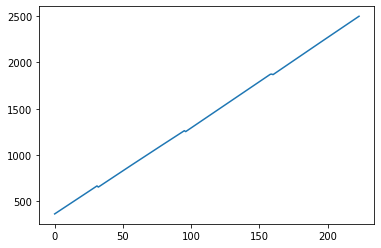

In [7]:
wavelengths_original = np.array(img.bands.centers)
print('Число каналов: ', len(wavelengths_original))
print('Минимальная длина волн: ', min(wavelengths_original))
print('Максимальная длина волн: ', max(wavelengths_original))
pylab.plot(wavelengths_original)

Видно что на трёх местах длина волн не возрастает монотонно. В частности, на 32ом элементе падает.

In [8]:
print(wavelengths_original[28:38])

[638.1865 647.9736 657.7651 667.561  655.2923 665.0994 674.9012 684.6979
 694.4894 704.2756]


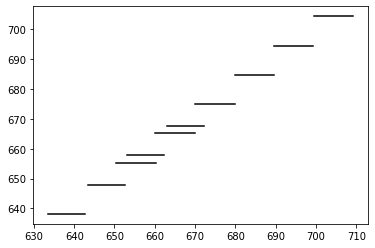

In [9]:
local_wl_centers = np.array(img.bands.centers[28:38])
local_bandwidths = np.array(img.bands.bandwidths[28:38])
band_starts = local_wl_centers - local_bandwidths / 2
band_ends = local_wl_centers + local_bandwidths / 2

pylab.figure()
for (c, s, e) in zip(local_wl_centers, band_starts, band_ends):
    pylab.plot([s, e], [c, c], color='black')

pylab.show()

Кроме того что они не в возрастающем порядке, они также значительно пересекаются. Отсортируем их.

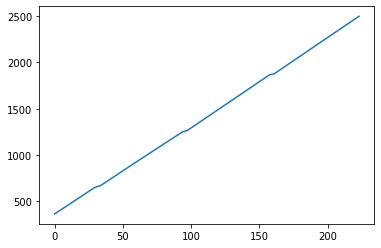

In [10]:
wavelengths_sorted = np.sort(wavelengths_original)
pylab.plot(wavelengths_sorted)

In [11]:
some_spectrum = img[1220, 496].astype(float)
resampler = BandResampler(wavelengths_original, wavelengths_sorted, img.bands.bandwidths)
some_spectrum_resampled = resampler(some_spectrum)

Посмотрим как выглядят графики, оригинальный, с отсортированными длинами волн, и с отсортированными длинами волн и соответствующей корректировкой измерений.

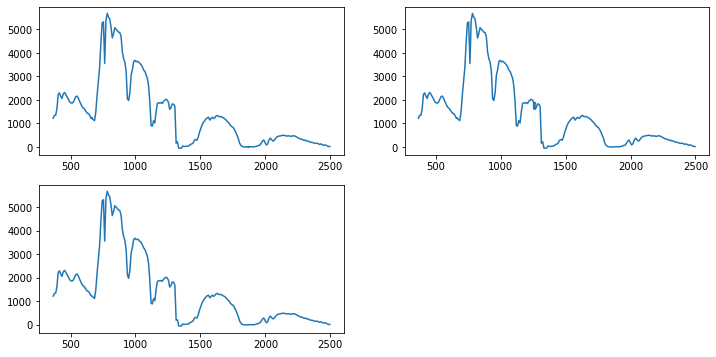

In [12]:
fig = pylab.figure()
fig.set_size_inches(3*4, 1*6)
pylab.subplot(2, 2, 1)
pylab.plot(wavelengths_original, some_spectrum)
pylab.subplot(2, 2, 2)
pylab.plot(wavelengths_sorted, some_spectrum)
pylab.subplot(2, 2, 3)
pylab.plot(wavelengths_sorted, some_spectrum_resampled)
pylab.show()

Посмотрим часть которая нам была интересной сначала.

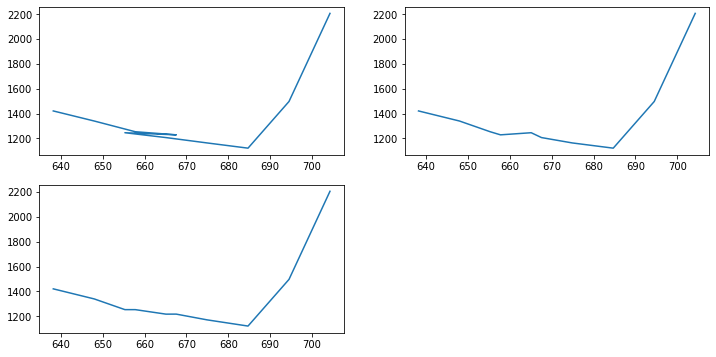

In [13]:
fig = pylab.figure()
fig.set_size_inches(3*4, 1*6)
pylab.subplot(2, 2, 1)
pylab.plot(wavelengths_original[28:38], some_spectrum[28:38])
pylab.subplot(2, 2, 2)
pylab.plot(wavelengths_sorted[28:38], some_spectrum[28:38])
pylab.subplot(2, 2, 3)
pylab.plot(wavelengths_sorted[28:38], some_spectrum_resampled[28:38])
pylab.show()

Видно что сортировка помогла. Посмотрим ещё одну интересную часть.

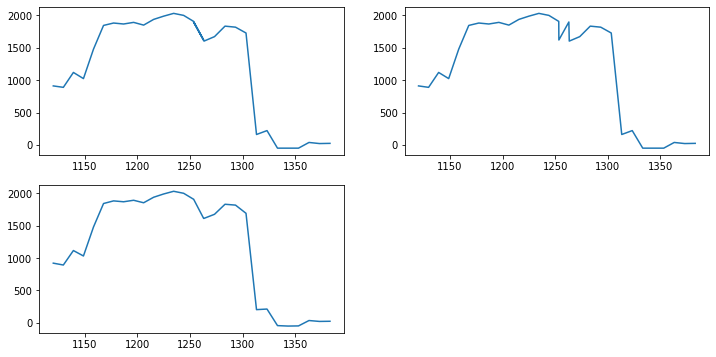

In [14]:
fig = pylab.figure()
fig.set_size_inches(3*4, 1*6)
pylab.subplot(2, 2, 1)
pylab.plot(wavelengths_original[80:110], some_spectrum[80:110])
pylab.subplot(2, 2, 2)
pylab.plot(wavelengths_sorted[80:110], some_spectrum[80:110])
pylab.subplot(2, 2, 3)
pylab.plot(wavelengths_sorted[80:110], some_spectrum_resampled[80:110])
pylab.show()

Тут ещё видно что нам нужно ещё и значения скорректировать. Поэтому, исправим целое изображение.

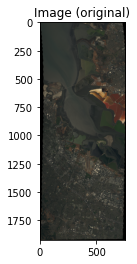

In [82]:
view = imshow(img, (29, 20, 12), title="Image (original)")

In [16]:
data = img[:,:,:]
#data = img[400:1000, 200:, :]
#data = img[400:700, 200:400, :]

In [17]:
data[data <= 0] = 1
print(data.dtype)

>i2


In [18]:
img_width = data.shape[0]
img_height = data.shape[1]
img_depth = data.shape[2]
data = np.dot(data.reshape(img_width*img_height, img_depth), resampler.matrix.T)
data = data.reshape(img_width, img_height, img_depth)

In [19]:
wavelengths = wavelengths_sorted
wavelengths_um = wavelengths / 1000
wavelengths_range = wavelengths[-1] - wavelengths[0]
wavelengths_range_um = wavelengths_um[-1] - wavelengths_um[0]

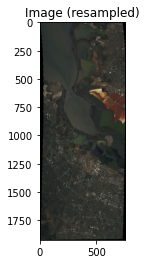

In [20]:
view = imshow(data, (29, 20, 12), title="Image (resampled)")

Будем проверять работу алгоритмов используя несколько интересных сигнатур.

1. Травы
2. Асфальта
3. Морской воды
4. Бетона

Надо упомянуть что особенно травы и воды могут быть разные. Вода может быть в большей или меньшей степени загрязненной, трава свежей или сухой, итд. Все ниже выбранные сигнатуры находятся около самого аэродрома.

In [21]:
interesting_spectra = [data[1220, 496].astype(float),
                          data[1227, 423].astype(float),
                          data[1177, 505].astype(float),
                          data[1258, 499].astype(float),
                         ]
interesting_colors = ['green', 'darkgrey', 'blue', 'lightgrey']
interesting_continuum_colors =  ['lightgreen', 'grey', 'lightblue', 'yellow']

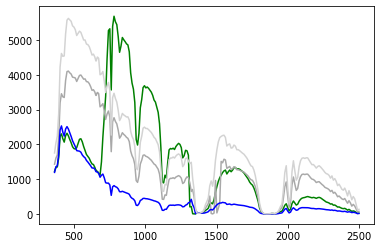

In [22]:
from visual_utils import draw_ontop
draw_ontop(interesting_spectra, wavelengths, interesting_colors)

Проверим работу функции удаления континуума написанных на С.

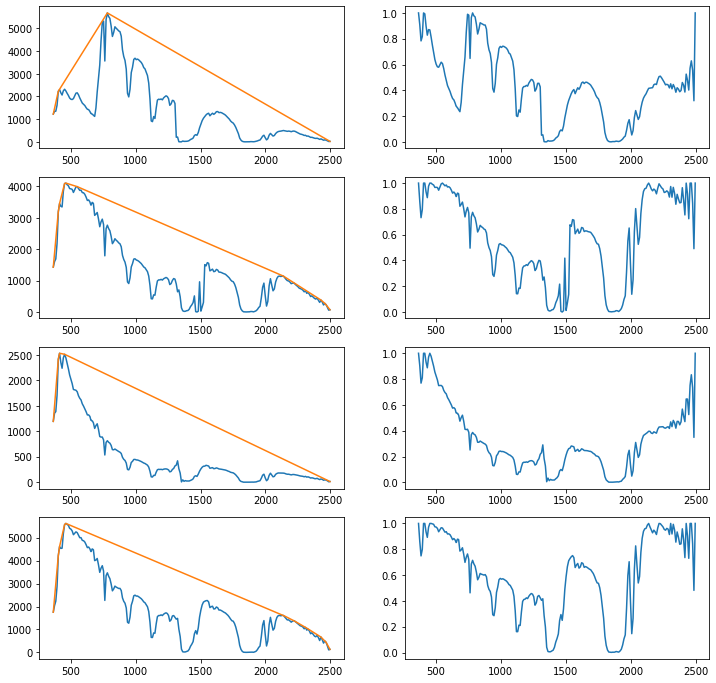

In [23]:
from ccontinuum import continuum, continuum_removed
from visual_utils import draw_common_2cols_graphs
inarr = np.asarray(interesting_spectra)
outarr = np.empty_like(inarr)
outarr_rem = np.empty_like(inarr)
continuum(inarr, outarr, wavelengths)
continuum_removed(inarr, outarr_rem, wavelengths)

graphs = []

for i in range(inarr.shape[0]):
    graphs.append([
        [inarr[i], outarr[i]],
        [outarr_rem[i]]
    ])

draw_common_2cols_graphs(graphs, wavelengths)

Проверим работу функции удаления континуума на питоне.

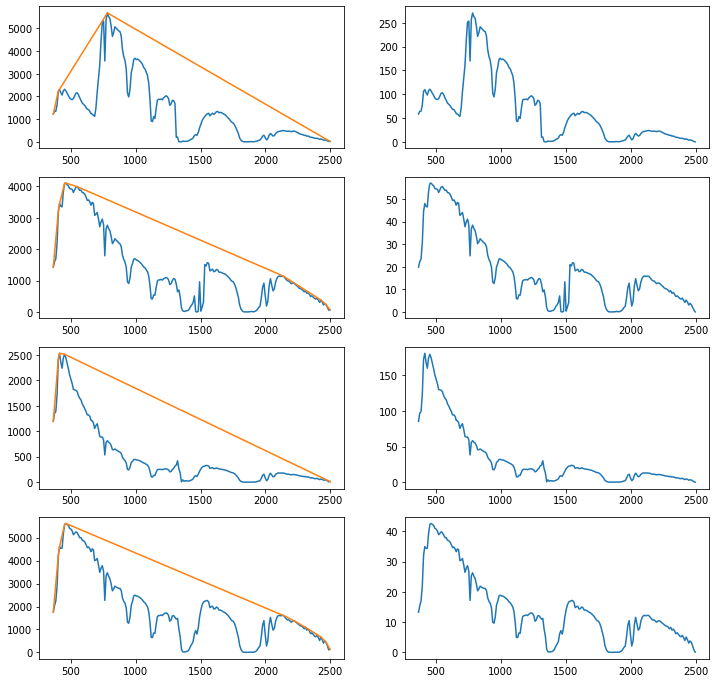

In [24]:
from pycontinuum import continuum, continuum_removed
from visual_utils import draw_common_2cols_graphs

graphs = []

for ispec in interesting_spectra:
    cont = continuum(ispec, wavelengths)
    cont_removed = continuum_removed(ispec, cont)
    graphs.append([
        [ispec, cont],
        [cont_removed]
    ])

draw_common_2cols_graphs(graphs, wavelengths)

Проверим работу функции вычисления частичного континуума на питоне.

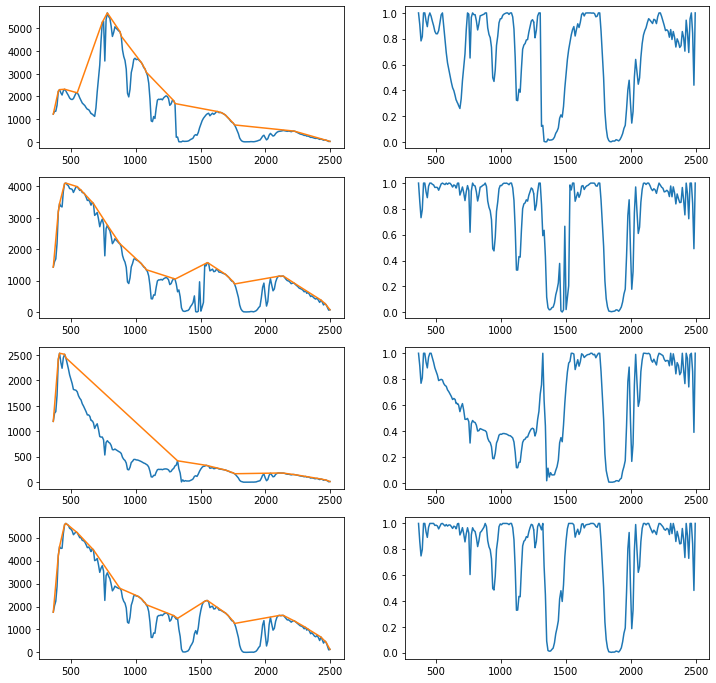

In [25]:
from pycontinuum import continuum_original, continuum_removed_original
from visual_utils import draw_common_2cols_graphs
step = 8
graphs = []

for ispec in interesting_spectra:
    cont = continuum_original(ispec, wavelengths, step)
    cont_removed = continuum_removed_original(ispec, cont)
    graphs.append([
        [ispec, cont],
        [cont_removed]
    ])

draw_common_2cols_graphs(graphs, wavelengths)

Также Б-сплайны с частичными континуумами.

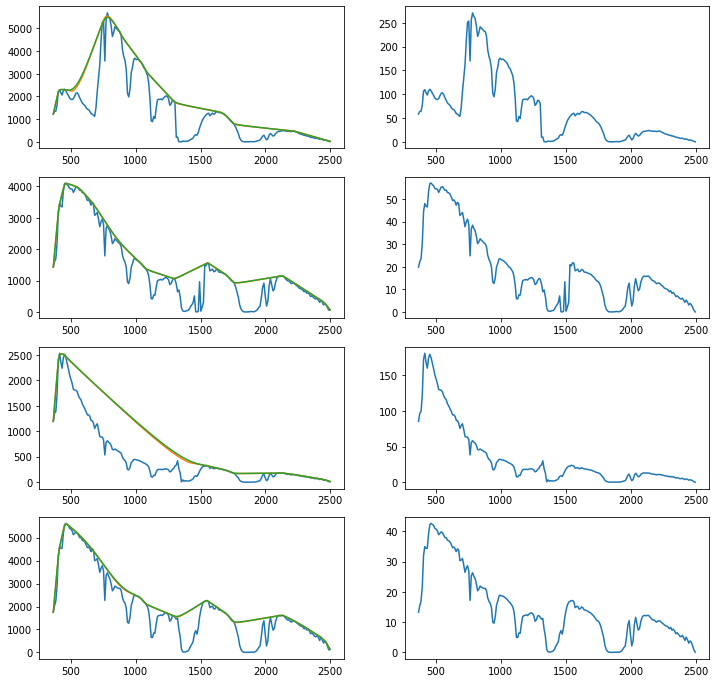

In [26]:
from pycontinuum import continuum_original, continuum_removed_original, continuum_points_original
from custo_math_funcs import bspline3_from_points, bspline2_from_points
from visual_utils import draw_common_2cols_graphs
step = 8
graphs = []

for ispec in interesting_spectra:
    cont = continuum_original(ispec, wavelengths, step)
    points = continuum_points_original(ispec, wavelengths, step)
    cont_bspline2 = bspline2_from_points(points, wavelengths)
    cont_bspline3 = bspline3_from_points(points, wavelengths)
    cont_removed = continuum_removed(ispec, cont_bspline3)
    graphs.append([
        [ispec, cont_bspline2, cont_bspline3],
        [cont_removed]
    ])

draw_common_2cols_graphs(graphs, wavelengths)

Kусочно-полиномиальная квадратичная интерполяция (piecewise quadratic polynomial interpolation, interpolating B-Spline)

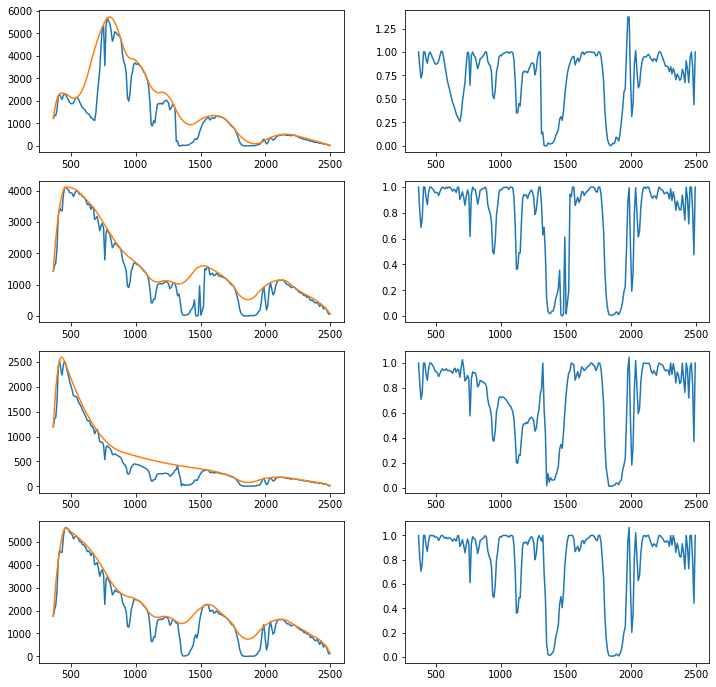

In [27]:
from pycontinuum import continuum_original, continuum_removed_original, continuum_points_original, interpolate_points
from visual_utils import draw_common_2cols_graphs
step = 8
graphs = []

for ispec in interesting_spectra:
    cont = continuum_original(ispec, wavelengths, step)
    points = continuum_points_original(ispec, wavelengths, step)
    interp_continuum  = interpolate_points(points, wavelengths, kind='quadratic')
    cont_removed = continuum_removed_original(ispec, interp_continuum)
    graphs.append([
        [ispec, interp_continuum],
        [cont_removed]
    ])

draw_common_2cols_graphs(graphs, wavelengths)

Посмотрим какие результаты получим после применения фильтра в частотной области.

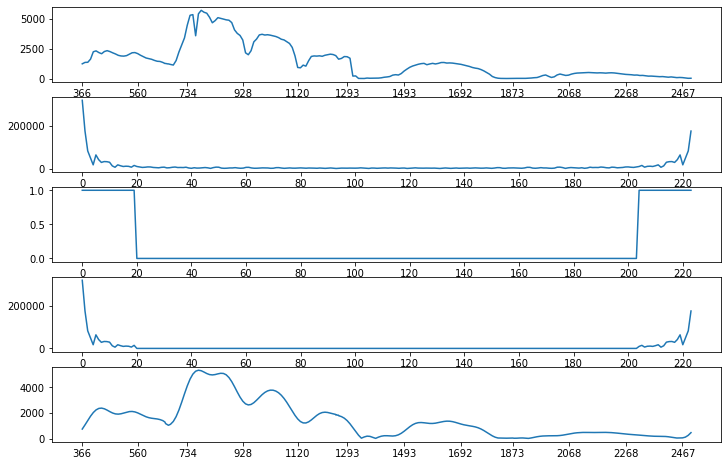

In [28]:
from scipy.fft import fft, ifft
from math_utils import square_signals
from visual_utils import draw_common_vert_plots

ispec = interesting_spectra[0]
freq_domain = fft(ispec)

stepf = square_signals(len(freq_domain), [(0, 20), (-20, len(freq_domain))])
filtered_freq = freq_domain * stepf

rsig = ifft(filtered_freq)

wl_xticks = wavelengths[::20]
length_xs = np.arange(len(wavelengths))
len_xticks = np.arange(0, len(wavelengths), 20)

graphs = [
    {'x': wavelengths, 'y': ispec, 'xticks': wl_xticks},
    {'x': length_xs, 'y': np.abs(freq_domain), 'xticks': len_xticks},
    {'x': length_xs, 'y': stepf, 'xticks': len_xticks},
    {'x': length_xs, 'y': np.abs(filtered_freq), 'xticks': len_xticks},
    {'x': wavelengths, 'y': np.abs(rsig), 'xticks': wl_xticks},
]

draw_common_vert_plots(graphs)

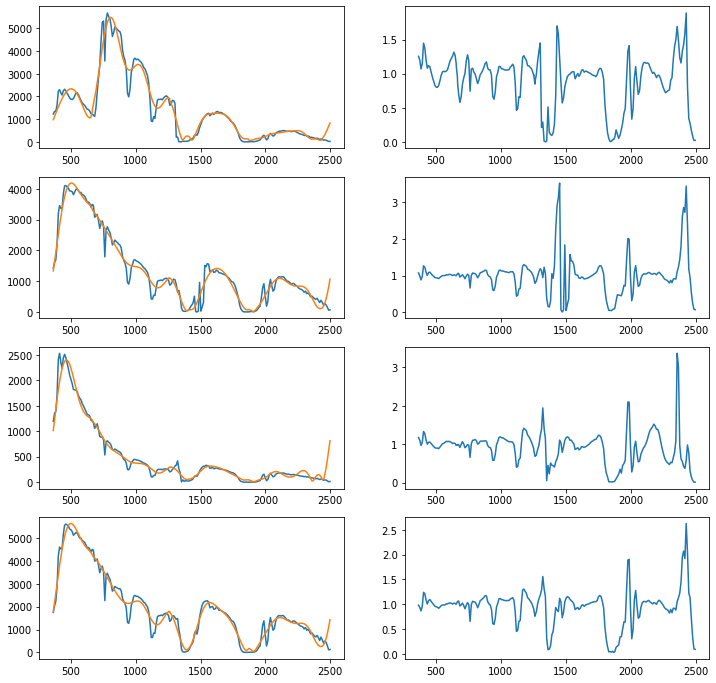

In [29]:
from math_utils import freq_square_filter
from visual_utils import draw_common_2cols_graphs
from pycontinuum import continuum_removed_original

graphs = []

take_n_outer = 10

for ispec in interesting_spectra:
    rsig = freq_square_filter(ispec, [(0, take_n_outer), (-take_n_outer, len(ispec))])
    cont_removed = continuum_removed_original(ispec, rsig)
    graphs.append([
        [ispec, rsig],
        [cont_removed]
    ])

draw_common_2cols_graphs(graphs, wavelengths)

Посмотрим какие результаты получим после применения фильтра скользящее среднее.

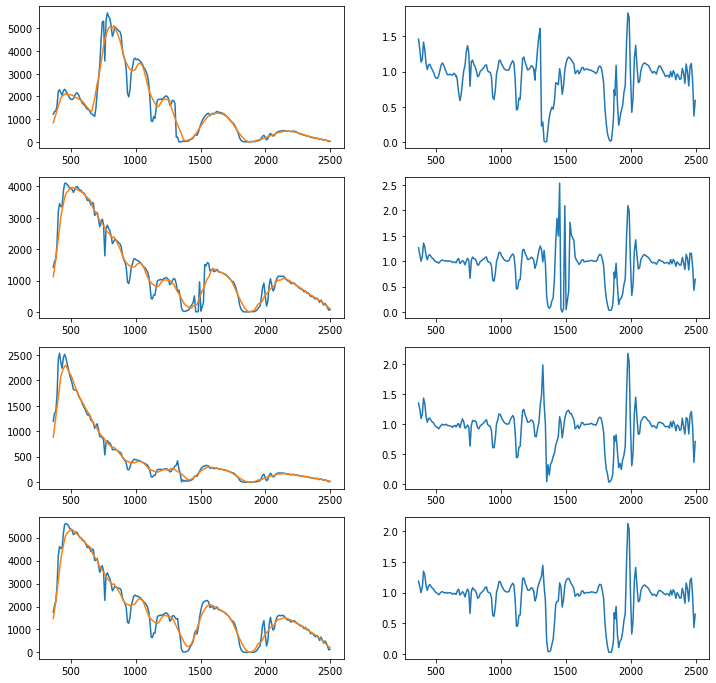

In [30]:
from math_utils import moving_average_filter
from visual_utils import draw_common_2cols_graphs
from pycontinuum import continuum_removed_original

graphs = []
avg_window = 12

for ispec in interesting_spectra:
    rsig = moving_average_filter(ispec, avg_window)
    cont_removed = continuum_removed_original(ispec, rsig)
    graphs.append([
        [ispec, rsig],
        [cont_removed]
    ])

draw_common_2cols_graphs(graphs, wavelengths)

Находим характерные сигнатуры изображения - максимумы, средние, самые удалённые от средней.

In [31]:
from utils import filter_out_invalid_spectra
spectra = filter_out_invalid_spectra(data)

In [32]:
avg = np.average(spectra, axis=0)
cr_avg = continuum_removed(avg, continuum(avg, wavelengths))

In [33]:
maxes = np.max(spectra, axis=0)
cr_maxes = continuum_removed(maxes, continuum(maxes, wavelengths))

In [34]:
from math_utils import find_max_diff_l2
max_diff_l2 = find_max_diff_l2(spectra, avg)
cr_max_diff_l2 = continuum_removed(max_diff_l2, continuum(max_diff_l2, wavelengths))

In [35]:
from math_utils import find_max_diff_l1
max_diff_l1 = find_max_diff_l1(spectra, avg)
cr_max_diff_l1 = continuum_removed(max_diff_l1, continuum(max_diff_l1, wavelengths))

In [36]:
from math_utils import find_max_diff_angle
max_diff_angle = find_max_diff_angle(spectra, avg)
cr_max_diff_angle = continuum_removed(max_diff_angle, continuum(max_diff_angle, wavelengths))

In [37]:
from math_utils import find_with_max_norm2
max_norm2 = find_with_max_norm2(spectra)
cr_max_norm2 = continuum_removed(max_norm2, continuum(max_norm2, wavelengths))

In [38]:
from math_utils import find_with_max_norm1
max_norm1 = find_with_max_norm1(spectra)
cr_max_norm1 = continuum_removed(max_norm1, continuum(max_norm1, wavelengths))

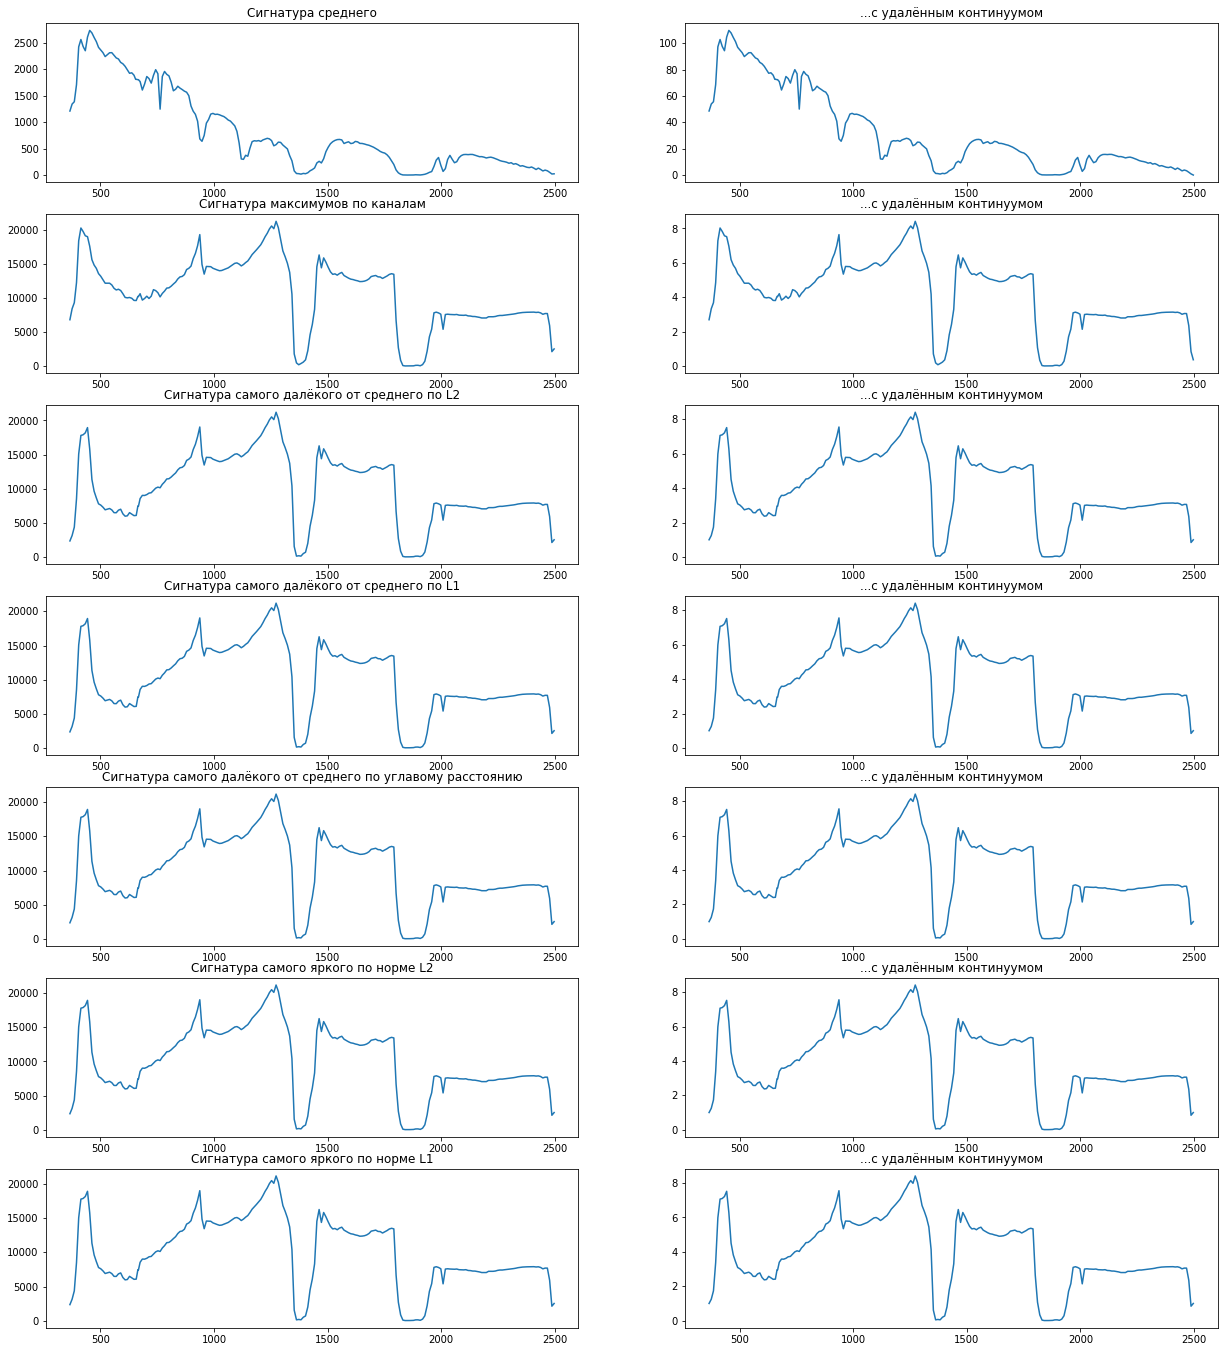

In [39]:
figs = [
    {
     'title': 'Сигнатура среднего',
     'sig': avg,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_avg
    },
    {
     'title': 'Сигнатура максимумов по каналам',
     'sig': maxes,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_maxes
    },
    {
     'title': 'Сигнатура самого далёкого от среднего по L2',
     'sig': max_diff_l2,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_diff_l2
    },
    {
     'title': 'Сигнатура самого далёкого от среднего по L1',
     'sig': max_diff_l1,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_diff_l1
    },
    {
     'title': 'Сигнатура самого далёкого от среднего по углавому расстоянию',
     'sig': max_diff_angle,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_diff_angle
    },
    {
     'title': 'Сигнатура самого яркого по норме L2',
     'sig': max_norm2,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_norm2
    },
    {
     'title': 'Сигнатура самого яркого по норме L1',
     'sig': max_norm1,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_norm1
    }
]


fig = pylab.figure()
fig.set_size_inches(len(figs)*3, 2*12)

for i in range(len(figs)):
    ax = pylab.subplot(len(figs), 2, (i*2)+1)
    ax.set_title(figs[i]['title'])
    pylab.plot(wavelengths, figs[i]['sig'])
    ax = pylab.subplot(len(figs), 2, (i*2)+2)
    ax.set_title(figs[i]['cr-title'])
    pylab.plot(wavelengths, figs[i]['cr-sig'])

pylab.show()

Посмотрим где находится самая отличающаяся сигнатура.

In [40]:
from utils import find_image_coords_of_spectrum
coords = find_image_coords_of_spectrum(data, max_diff_l2)
print(coords)

(1315, 98)


Посмотрим как будет выглядет если удалят континуум на основе (Б-сплайна) максимумов.

(array([ 365.9298,  404.6129,  414.2946, 1273.318 , 2467.273 , 2497.036 ]), array([ 6794.92654434, 18352.42815227, 20226.        , 21204.72387803,
        7700.58636533,  2519.58606119]))


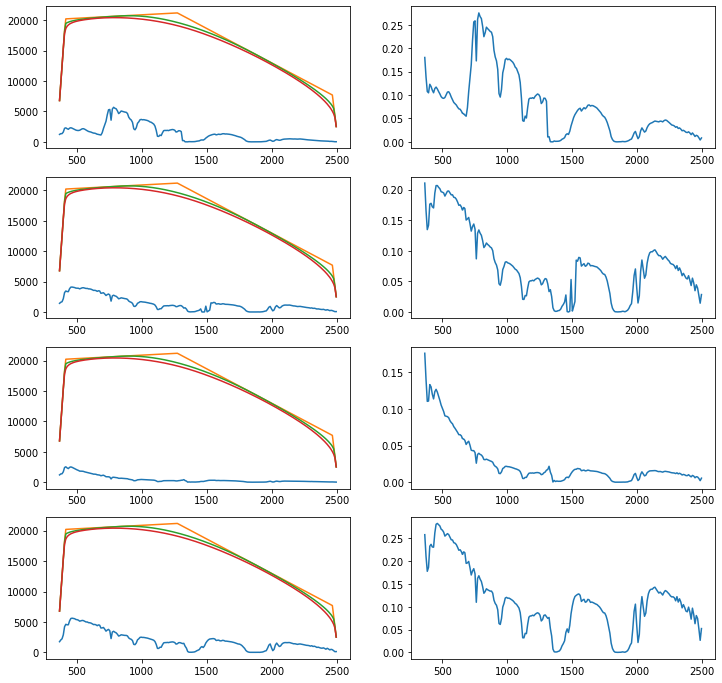

In [41]:
from pycontinuum import continuum, continuum_removed_original, continuum_points
from custo_math_funcs import bspline3_from_points, bspline2_from_points
from visual_utils import draw_common_2cols_graphs

graphs = []
cont = continuum(maxes, wavelengths)
cont_points = continuum_points(maxes, wavelengths)
print(cont_points)
cont_bspline2 = bspline2_from_points(cont_points, wavelengths)
cont_bspline3 = bspline3_from_points(cont_points, wavelengths)

for ispec in interesting_spectra:
    cont_removed = continuum_removed_original(ispec, cont_bspline2)
    graphs.append([
        [ispec, cont, cont_bspline2, cont_bspline3],
        [cont_removed]
    ])

draw_common_2cols_graphs(graphs, wavelengths)

Kусочно-полиномиальная квадратичная интерполяция (piecewise quadratic polynomial interpolation, interpolating B-Spline)

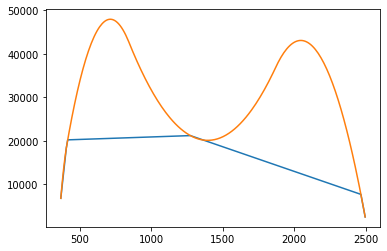

In [42]:
from pycontinuum import continuum, continuum_points, interpolate_points
cont = continuum(maxes, wavelengths)
cont_points = continuum_points(maxes, wavelengths)
cont_interp = interpolate_points(cont_points, wavelengths, kind='quadratic')
pylab.plot(wavelengths, cont)
pylab.plot(wavelengths, cont_interp)

Кажется лучше просто взять простой линейный континуум сигнатуры максимумов и будем удалять континуум на его основе и сравнивать с эталонами. Хотя, провалы на некоторых местах в спектре могут испортить результат. Поэтому посмотрим что получится если просто разделить сигнатуры на поканальные максимумы.

Характеристики разных материалов очевидно содержаны в низкочастотных слагаемых. Поэтому,  стоит отфильтровать сигнатуры до, либо после удаления континуума, чтобы избавиться от высокочастотного шума. На взгляд кажется что простой вариант с скользящим средним работает хорошо.

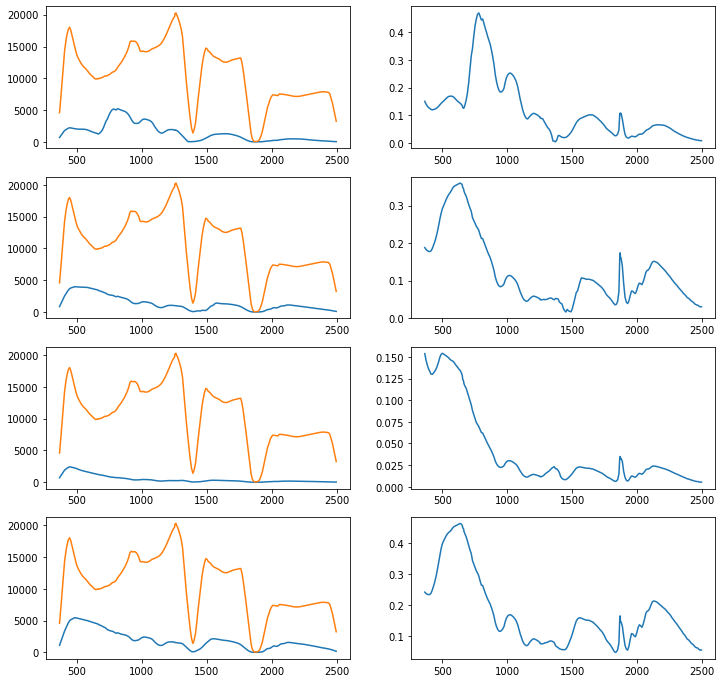

In [43]:
from pycontinuum import continuum, continuum_removed_original
from visual_utils import draw_common_2cols_graphs
from math_utils import moving_average_filter

graphs = []
avg_window = 8

maxes_filtered = moving_average_filter(maxes, avg_window)

for ispec in interesting_spectra:
    ispec = moving_average_filter(ispec, avg_window)
    cont_removed = continuum_removed_original(ispec, maxes_filtered)
    #cont_removed_filtered = moving_average_filter(cont_removed, avg_window)
    graphs.append([
        [ispec, maxes_filtered],
        [cont_removed]
    ])

draw_common_2cols_graphs(graphs, wavelengths)

Провалы в максимумах дают блики в результате. Поэтому определить отражаемость придется другим способом. Частичный континуум + квадратичная интерполяция на глаз дают хороший график. Попробуем. Но попробуем потом и что нибудь более на точной науке обосновано.

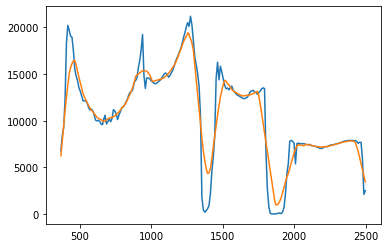

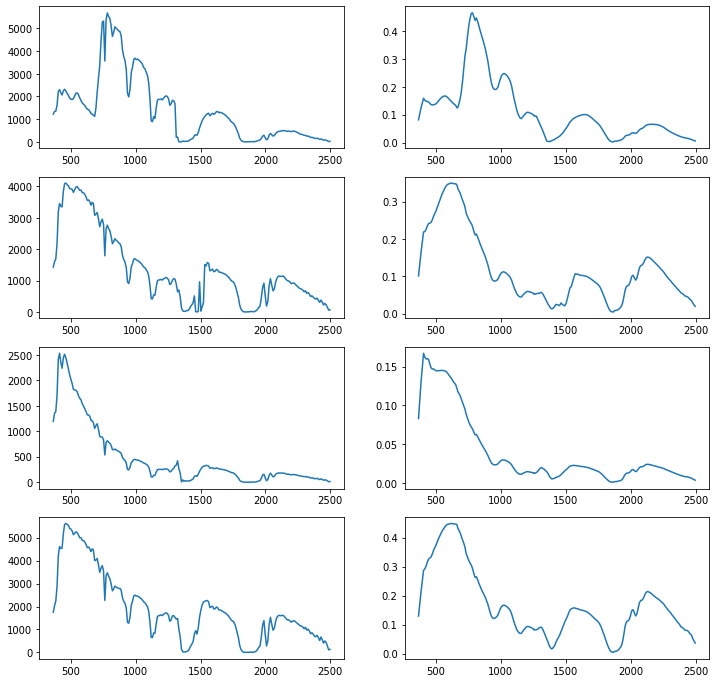

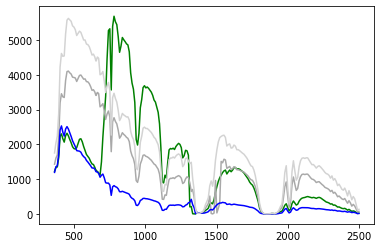

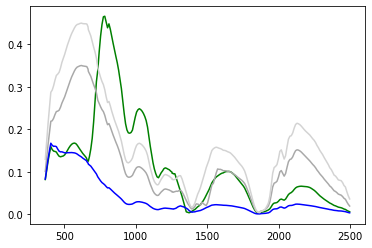

In [44]:
from pycontinuum import continuum, continuum_removed_original, continuum_points, interpolate_points
from visual_utils import draw_common_2cols_graphs, draw_ontop
from math_utils import moving_average_filter

graphs = []
avg_window = 8
step = 1

cont_points = continuum_points_original(maxes, wavelengths, step)
maxes_lin_interp = interpolate_points(cont_points, wavelengths, kind='slinear')
maxes_processed = moving_average_filter(np.clip(maxes, 1000, 20000), 12)

draw_ontop([maxes, maxes_processed], wavelengths)

reflectances = []

for ispec in interesting_spectra:
    #ispec = moving_average_filter(ispec, avg_window)
    cont_removed = continuum_removed_original(ispec, maxes_processed)
    cont_removed_filtered = moving_average_filter(cont_removed, avg_window)
    graphs.append([
        [ispec],
        [cont_removed_filtered]
    ])
    reflectances.append(cont_removed_filtered)

draw_common_2cols_graphs(graphs, wavelengths)

draw_ontop(interesting_spectra, wavelengths, ['green', 'darkgrey', 'blue', 'lightgrey'])
draw_ontop(reflectances, wavelengths, ['green', 'darkgrey', 'blue', 'lightgrey'])

Читаем эталон травы (40% сухая, 60% зеленая) снят спектрометром Бэкман. В конце интерполируем невалидные значения.

splib07a Record=24163: Grass_dry.4+.6green AMX27 BECKa AREF 	 480 channels


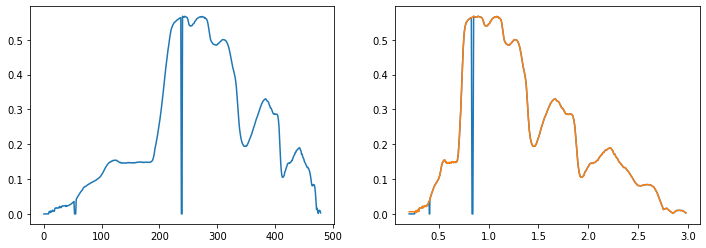

In [46]:
from usgs_splib_utils import SpectralData
grassa_ethalon = SpectralData.read_from_file('grass/splib07a_Grass_dry.4+.6green_AMX27_BECKa_AREF.txt')
grassa_ethalon.replace_invalid(0.0)
print(grassa_ethalon)
pylab.figure().set_size_inches(12, 4)
pylab.subplot(1, 2, 1)
pylab.plot(grassa_ethalon.spectrum)
pylab.subplot(1, 2, 2)
pylab.plot(grassa_ethalon.spectrometer_data.wavelengths, grassa_ethalon.spectrum)
grassa_ethalon.interpolate_invalid()
pylab.plot(grassa_ethalon.spectrometer_data.wavelengths, grassa_ethalon.spectrum)
pylab.show()

Посмотрим как выглядят длины волн.

splib07a Record=20: Bandpass BECK BECK Beckman in microns 	 wavelengths from 0.2051 to 2.9760001
splib07a Record=89: Bandpass AVIRIS AVIRIS 1996 in microns 	 wavelengths from 0.37049001 to 2.5075898


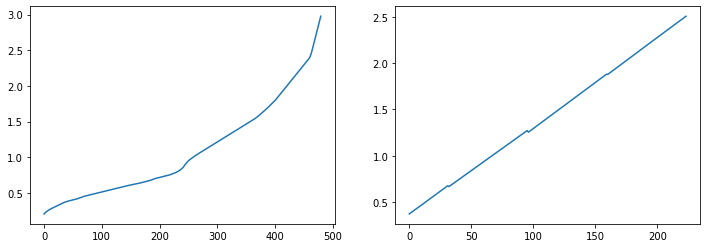

In [47]:
from usgs_splib_utils import SpectrometerData
fig = pylab.figure()
fig.set_size_inches(12, 4)
pylab.subplot(1, 2, 1)
beck_sm = SpectrometerData.get_by_name('BECK')
print(beck_sm)
pylab.plot(beck_sm.wavelengths)
pylab.subplot(1, 2, 2)
aviris_sm = SpectrometerData.get_by_name('AVIRIS')
print(aviris_sm)
pylab.plot(aviris_sm.wavelengths)
pylab.show()

С авирисом известная проблема. Его надо исправлять.

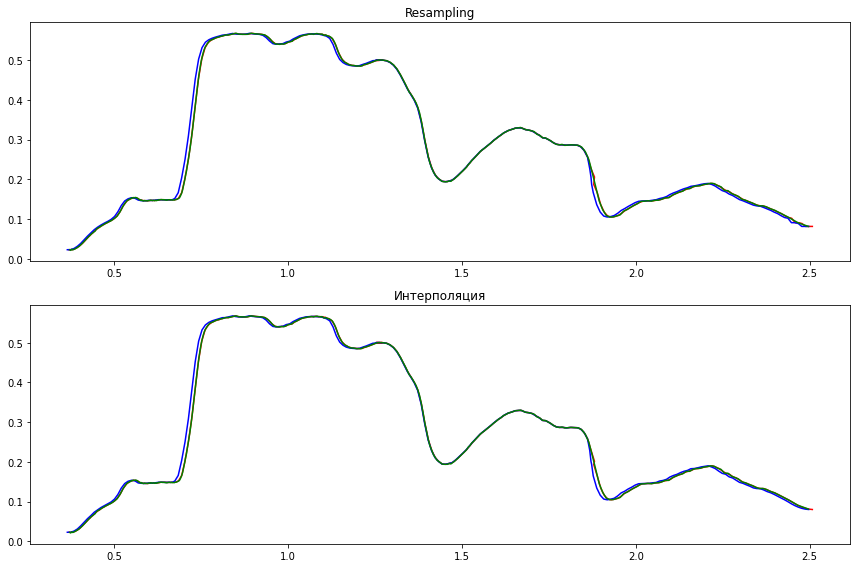

In [48]:
import usgs_splib_utils

fig = pylab.figure()
fig.set_size_inches(12, 8)
fig.set_tight_layout(True)

beck_av_range_wl, beck_av_range_sig = grassa_ethalon.in_range_of('AVIRIS')

as_aviris = grassa_ethalon.resample_as('AVIRIS', True)
pylab.subplot(2, 1, 1).set_title('Resampling')
pylab.plot(SpectrometerData.get_by_name('AVIRIS').wavelengths, as_aviris, color='red')
pylab.plot(wavelengths_um, as_aviris, color='blue')
pylab.plot(beck_av_range_wl, beck_av_range_sig, color='green')

as_aviris = grassa_ethalon.interpolate_as('AVIRIS', True)
pylab.subplot(2, 1, 2).set_title('Интерполяция')
pylab.plot(SpectrometerData.get_by_name('AVIRIS').wavelengths, as_aviris, color='red')
pylab.plot(wavelengths_um, as_aviris, color='blue')
pylab.plot(beck_av_range_wl, beck_av_range_sig, color='green')

pylab.show()

Оба метода га глаз дают одинаково хороший результат. Получаем идеальное совпадение, но длины волн из ENVI не совпадают.

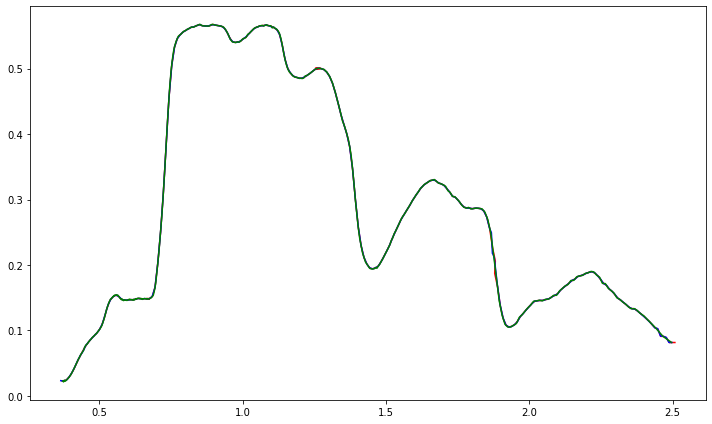

In [49]:
import usgs_splib_utils

fig = pylab.figure()
fig.set_size_inches(10, 6)
fig.set_tight_layout(True)

as_aviris = grassa_ethalon.resample_as('AVIRIS', True)
pylab.plot(SpectrometerData.get_by_name('AVIRIS').wavelengths, as_aviris, color='red')

as_aviris = grassa_ethalon.resample_at(wavelengths_um)
pylab.plot(wavelengths_um, as_aviris, color='blue')

beck_av_range_wl, beck_av_range_sig = grassa_ethalon.in_range_of('AVIRIS')
pylab.plot(beck_av_range_wl, beck_av_range_sig, color='green')

pylab.show()

Отдельной интерполяцией длинами волн из ENVI получаем идеальное совпадение.

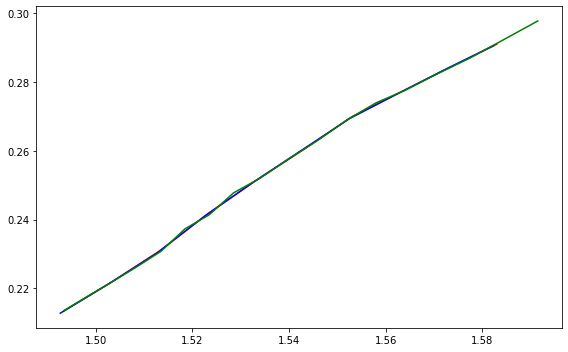

In [50]:
import usgs_splib_utils
from utils import lower_bound, upper_bound

fig = pylab.figure()
fig.set_size_inches(8, 5)
fig.set_tight_layout(True)

min_index = 120
max_index = 130
usgs_av_wavelengths = SpectrometerData.get_by_name('AVIRIS').wavelengths

as_aviris = grassa_ethalon.resample_as('AVIRIS', True)
pylab.plot(usgs_av_wavelengths[min_index:max_index], as_aviris[min_index:max_index], color='red')

as_aviris = grassa_ethalon.resample_at(wavelengths_um)
pylab.plot(wavelengths_um[min_index:max_index], as_aviris[min_index:max_index], color='blue')

beck_av_range_wl, beck_av_range_sig = grassa_ethalon.in_range_of('AVIRIS')
min_index = lower_bound(beck_av_range_wl, usgs_av_wavelengths[min_index])
max_index = upper_bound(beck_av_range_wl, usgs_av_wavelengths[max_index])
pylab.plot(beck_av_range_wl[min_index:max_index], beck_av_range_sig[min_index:max_index], color='green')

pylab.show()

...ну, не 100%. Но теперь знаем начальные шаги для сравнения сигнатур изображения и эталона.

In [51]:
interesting_ethalons = [
    SpectralData.read_from_file('grass/splib07a_Grass_dry.4+.6green_AMX27_BECKa_AREF.txt')
        .interpolate_invalid()
        .resample_at(wavelengths_um),
    SpectralData.read_from_file('asphalt/splib07a_Asphalt_Shingle_GDS368_Lgray_ASDFRa_AREF.txt') \
        .interpolate_invalid()
        .resample_at(wavelengths_um),
    SpectralData.read_from_file('seawater/splib07a_Seawater_Coast_Chl_SW1_BECKa_AREF.txt') \
        .interpolate_invalid()
        .resample_at(wavelengths_um),
    SpectralData.read_from_file('concrete/splib07a_Concrete_GDS375_Lt_Gry_Road_ASDFRa_AREF.txt') \
        .interpolate_invalid()
        .resample_at(wavelengths_um),
]

In [52]:
def img2reflect(img_sig, filter_step=8, scale_vec=maxes_processed):
    return moving_average_filter(img_sig / scale_vec, filter_step)
interesting_reflectances = [img2reflect(ispec, scale_vec=maxes_processed) for ispec in interesting_spectra]

In [53]:
def compare_plots_with_ethalon(ethalon, ethalong_color, interesting_reflectances):
    from pycontinuum import continuum, continuum_removed_original

    spectra = [ethalon] + interesting_reflectances
    colors = [ethalong_color] + interesting_colors

    pylab.figure().set_size_inches(16, 6)
    pylab.subplot(1, 2, 1)
    for i, s, in enumerate(spectra):
        pylab.plot(wavelengths, s, color=colors[i])
    pylab.subplot(1, 2, 2)
    for i, s, in enumerate(spectra):
        cont = continuum(s, wavelengths)
        crs = continuum_removed_original(s, cont)
        pylab.plot(wavelengths, crs, color=colors[i])


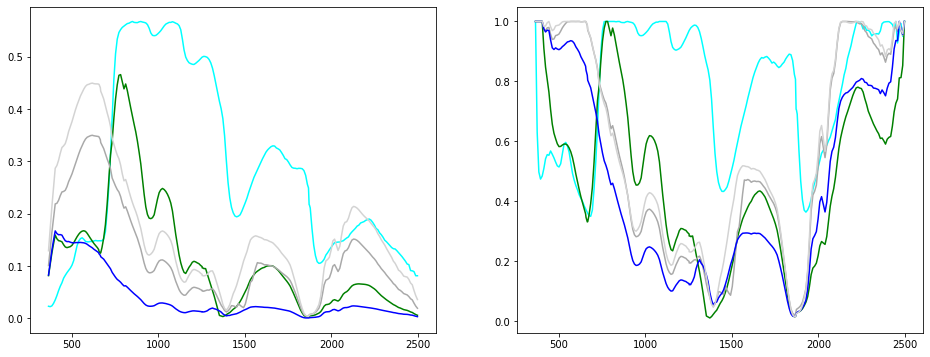

In [54]:
compare_plots_with_ethalon(interesting_ethalons[0], 'cyan', interesting_reflectances)

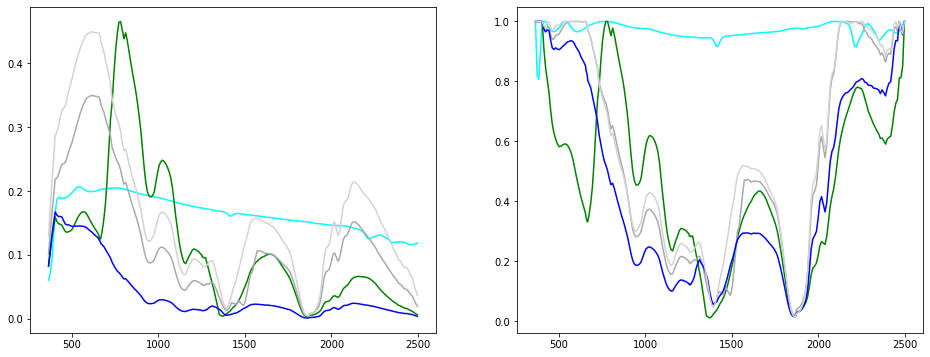

In [55]:
compare_plots_with_ethalon(interesting_ethalons[1], 'cyan', interesting_reflectances)

Если удалить частичные континуумы, то результаты должны лучше совпадать.

In [56]:
def compare_ethalon_imgrefl_continuum(ethalon_i, imgrefl_i, ethalon_color, ethalon_continuum_color, interesting_reflectances, mode):
    from pycontinuum import continuum, continuum_removed_original, interpolate_points
    from spectral.algorithms.continuum import continuum_points

    spectra = [interesting_ethalons[ethalon_i], interesting_reflectances[imgrefl_i]]
    colors = [ethalon_color, interesting_colors[imgrefl_i]]
    continuum_colors = [ethalon_continuum_color, interesting_continuum_colors[imgrefl_i]]

    continuums = []

    for i, s in enumerate(spectra):
        points = continuum_points(s, wavelengths, mode=mode)
        cont = interpolate_points(points, wavelengths, kind='slinear')
        continuums.append(cont)

    pylab.figure().set_size_inches(16, 6)
    pylab.subplot(1, 2, 1)
    for i, s, in enumerate(spectra):
        pylab.plot(wavelengths, s, color=colors[i])
        cont = continuums[i]
        pylab.plot(wavelengths, cont, color=continuum_colors[i])

    pylab.subplot(1, 2, 2)
    for i, s, in enumerate(spectra):
        cont = continuums[i]
        crs = continuum_removed_original(s, cont)
        pylab.plot(wavelengths, crs, color=colors[i])


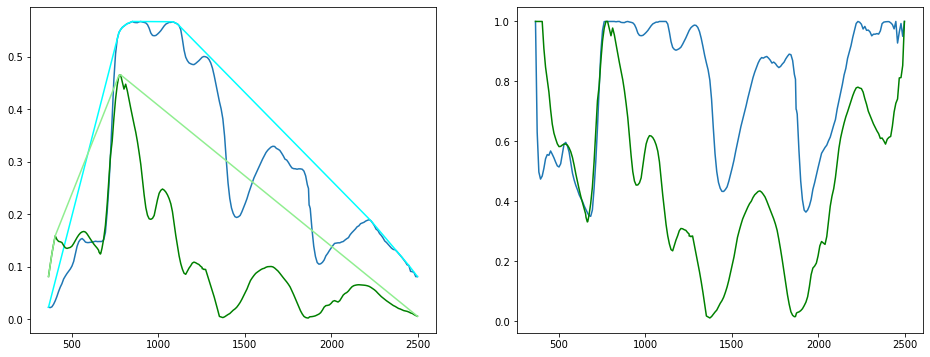

In [57]:
compare_ethalon_imgrefl_continuum(0, 0, 'tab:blue', 'cyan', interesting_reflectances, 'convex')

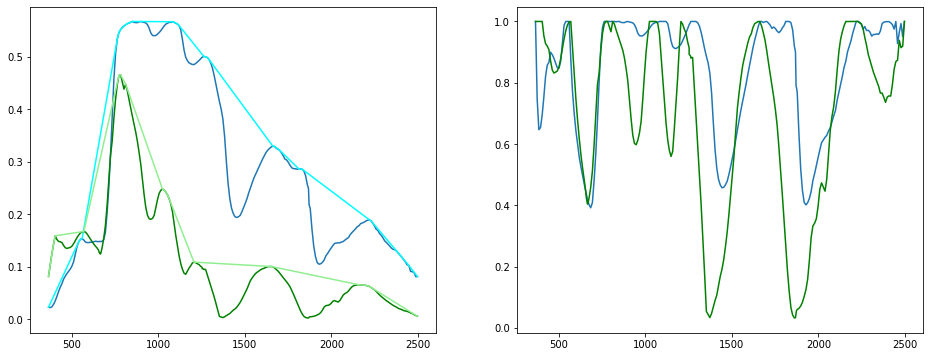

In [58]:
compare_ethalon_imgrefl_continuum(0, 0, 'tab:blue', 'cyan', interesting_reflectances, 'segmented')

Но может теперь и асфальт с травой совпадает лучше.

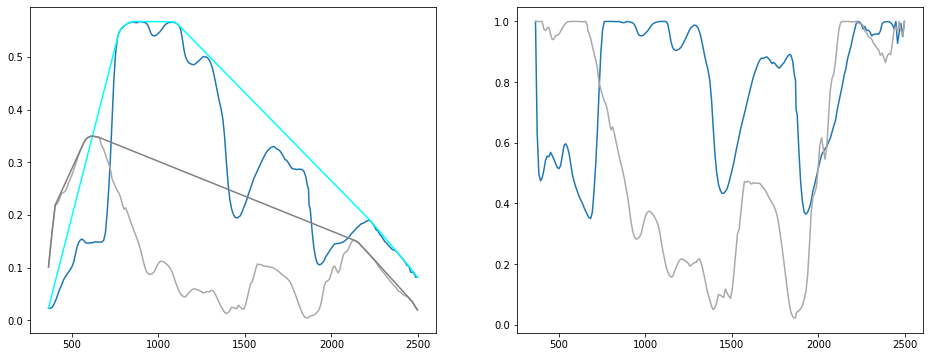

In [59]:
compare_ethalon_imgrefl_continuum(0, 1, 'tab:blue', 'cyan', interesting_reflectances, 'convex')

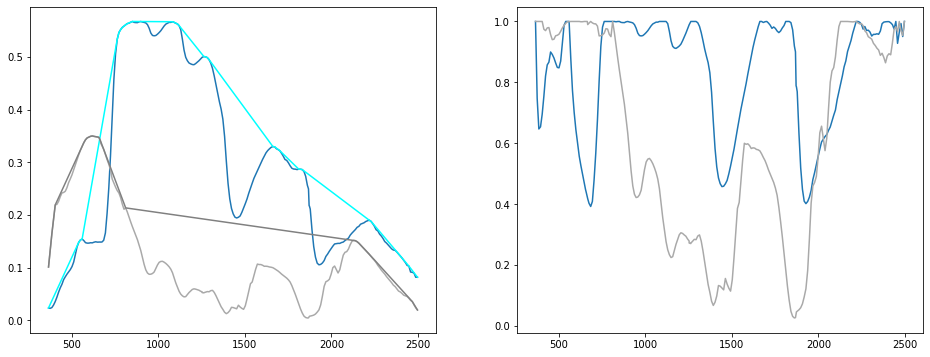

In [60]:
compare_ethalon_imgrefl_continuum(0, 1, 'tab:blue', 'cyan', interesting_reflectances, 'segmented')

...да, но не настолько.

Попробуем вместо на максимум разделить на 10000.

In [61]:
interesting_reflectances = [img2reflect(ispec, scale_vec=(np.ones((len(ispec),), dtype=float) * 10000)) for ispec in interesting_spectra]

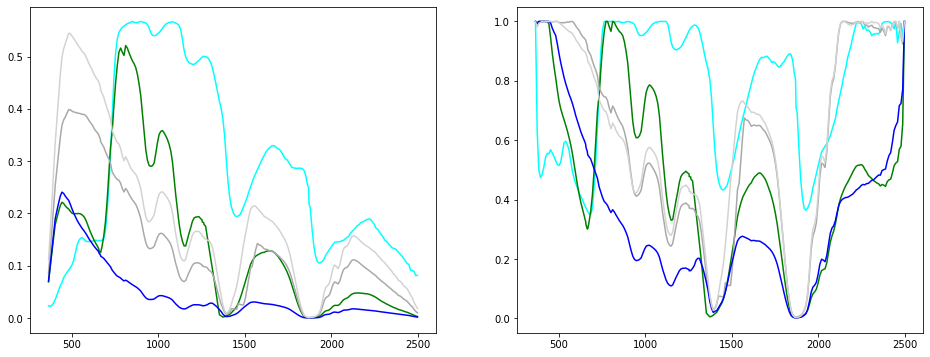

In [62]:
compare_plots_with_ethalon(interesting_ethalons[0], 'cyan', interesting_reflectances)

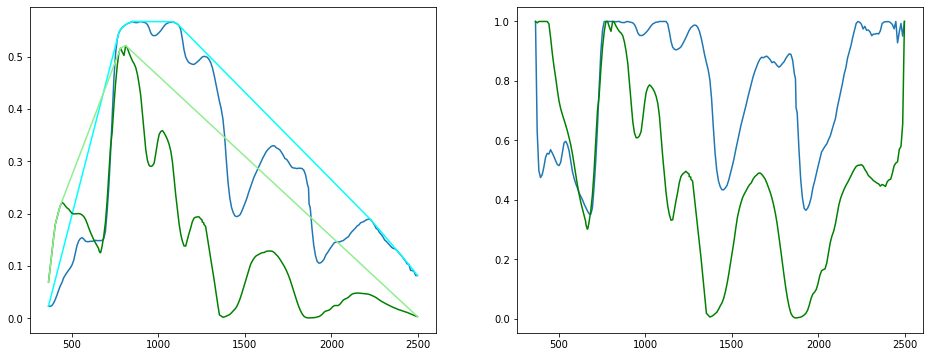

In [63]:
compare_ethalon_imgrefl_continuum(0, 0, 'tab:blue', 'cyan', interesting_reflectances, 'convex')

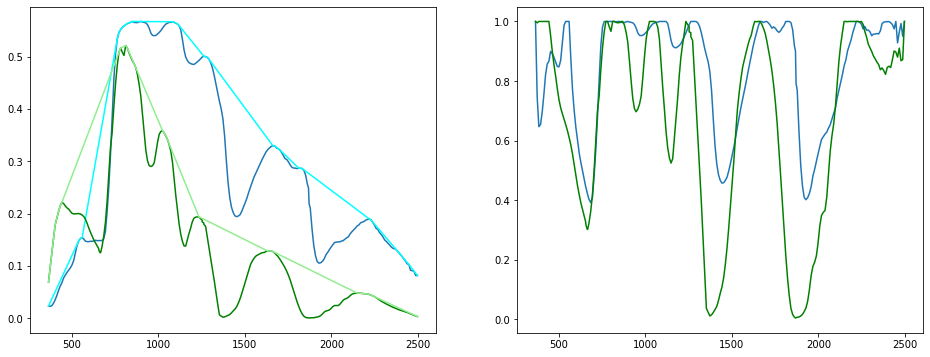

In [64]:
compare_ethalon_imgrefl_continuum(0, 0, 'tab:blue', 'cyan', interesting_reflectances, 'segmented')

Пока эталоны не совпадают с измерениями на изображении. И не только в масштабе. Трава, например, выглядит так:

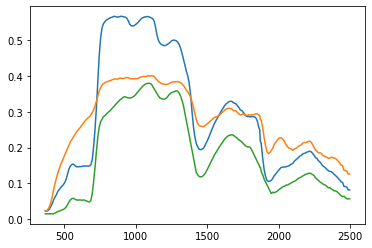

In [65]:
grass_files = ['grass/splib07a_Grass_dry.4+.6green_AMX27_BECKa_AREF.txt',
              'grass/splib07a_Grass_dry.9+.1green_AMX32_BECKa_AREF.txt',
              'grass/splib07a_Grass-FescueWheatg_YNP-FW-1_AVIRISb_RTGC.txt'
              ]

grass_spectra = [SpectralData.read_from_file(gf).interpolate_invalid().resample_at(wavelengths_um) \
                  for gf in grass_files]

draw_ontop(grass_spectra, wavelengths)

Посторим данные из ECOSTRESS библиотеки.

In [66]:
import spectral as spy
#db = spy.EcostressDatabase.create('ecostress.db', 'ecospeclib')
db = EcostressDatabase('ecostress.db')

In [67]:
for s in db.schemas:
    print('>', s)

> CREATE TABLE Samples (SampleID INTEGER PRIMARY KEY, Name TEXT, Type TEXT, Class TEXT, SubClass TEXT, ParticleSize TEXT, SampleNum TEXT, Owner TEXT, Origin TEXT, Phase TEXT, Description TEXT)
> CREATE TABLE Spectra (SpectrumID INTEGER PRIMARY KEY, SampleID INTEGER, SensorCalibrationID INTEGER, Instrument TEXT, Environment TEXT, Measurement TEXT, XUnit TEXT, YUnit TEXT, MinWavelength FLOAT, MaxWavelength FLOAT, NumValues INTEGER, XData BLOB, YData BLOB)


In [68]:
db.print_query('SELECT COUNT() FROM Samples WHERE Name LIKE "%grass%" OR Description LIKE "%grass%" OR Class LIKE "%grass%"')

9


In [69]:
db.print_query('SELECT SampleID, Name, Type, Class, SubClass, ParticleSize, Owner, Origin, Phase, Description FROM Samples WHERE Name LIKE "%grass%" limit 1')

1318|Grass|vegetation|grass|Unknown|none|JHU|The entire spectral range was measured at Johns Hopkins University--see file vegetata.doc for details.|unknown|Green Rye grass. Spectra were assembled from two segments; the bidirectional VNIR and SWIR comprising segment one and the hemispherical MWIR and TIR comprising segment two. The VNIR/SWIR spectrum was measured in the laboratory at JHU with a GER IRIS Mark IV using a large piece of sod.  The grass was illuminated from directly above and measured at a reflectance angle of 60 degrees to avoid viewing the thatch.


In [70]:
db.print_query('SELECT SampleID, Name, Type, Class, SubClass, ParticleSize, Owner, Origin, Phase FROM Samples WHERE Name LIKE "%grass%" OR Description LIKE "%grass%" OR Class LIKE "%grass%" limit 10')

321|Avena fatua|vegetation|grass|Avena|none|UCSB|34.5143; -119.798367; WGS84|unknown
668|Bromus diandrus|vegetation|grass|Bromus|none|UCSB|34.51457; -119.79877; WGS84|unknown
716|Bromus diandrus|vegetation|grass|Bromus|none|UCSB|34.51457; -119.79877; WGS84|unknown
808|Avena fatua|vegetation|grass|Avena|none|UCSB|34.5143; -119.798367; WGS84|unknown
830|Avena fatua|vegetation|grass|Avena|none|UCSB|34.5143; -119.798367; WGS84|unknown
1162|Avena fatua|vegetation|grass|Avena|none|UCSB|34.5143; -119.798367; WGS84|unknown
1318|Grass|vegetation|grass|Unknown|none|JHU|The entire spectral range was measured at Johns Hopkins University--see file vegetata.doc for details.|unknown
1322|Bromus diandrus|vegetation|grass|Bromus|none|UCSB|34.5143; -119.798367; WGS84|unknown
1572|Bromus diandrus|vegetation|grass|Bromus|none|UCSB|34.5143; -119.798367; WGS84|unknown


In [71]:
db.print_query('SELECT Description FROM Samples WHERE Name LIKE "%grass%" OR Class LIKE "%grass%" limit 10')

Samples were collected as part of the HyspIRI Airborne Campaign proposal titled: HyspIRI discrimination of plant species and functional types along a strong environmental temperature gradient. The same materials were processed in the Nicolet and then measured using the ASD.
Samples were collected as part of the HyspIRI Airborne Campaign proposal titled: HyspIRI discrimination of plant species and functional types along a strong environmental temperature gradient. The same materials were processed in the Nicolet and then measured using the ASD.
Samples were collected as part of the HyspIRI Airborne Campaign proposal titled: HyspIRI discrimination of plant species and functional types along a strong environmental temperature gradient. The same materials were processed in the Nicolet and then measured using the ASD.
Samples were collected as part of the HyspIRI Airborne Campaign proposal titled: HyspIRI discrimination of plant species and functional types along a strong environmental temp

In [72]:
grass_ids = [id for id, in db.query('SELECT SampleID FROM Samples WHERE Name LIKE "%grass%" OR Description LIKE "%grass%" OR Class LIKE "%grass%" limit 10')]
print(grass_ids)

[321, 668, 716, 808, 830, 1162, 1318, 1322, 1572]


In [73]:
string_ids = '(' + (', '.join([str(gid) for gid in grass_ids])) + ')'
query = f'SELECT SpectrumID, SampleID, SensorCalibrationID, Instrument, Environment, Measurement, XUnit, YUnit, MinWavelength, MaxWavelength, NumValues FROM Spectra WHERE SampleID IN {string_ids}'
db.print_query(query)

321|321|-1|grass|lab|Hemispherical reflectance|Wavelength (micrometer)|Reflectance (percentage)|2.501|15.341|1736
668|668|-1|grass|lab|Hemispherical reflectance|Wavelength (micrometer)|Reflectance (percentage)|2.501|15.341|1736
716|716|-1|grass|lab|Bidirectional reflectance|Wavelength (micrometer)|Reflectance (percentage)|0.35|2.5|2151
808|808|-1|grass|lab|Bidirectional reflectance|Wavelength (micrometer)|Reflectance (percentage)|0.35|2.5|2151
830|830|-1|grass|lab|Bidirectional reflectance|Wavelength (micrometer)|Reflectance (percentage)|0.35|2.5|2151
1162|1162|-1|grass|lab|Hemispherical reflectance|Wavelength (micrometer)|Reflectance (percentage)|2.501|15.341|1736
1318|1318|-1|grass|lab|Bidirectional and directional hemispherical reflectance.|Wavelength (micrometers)|Reflectance (percent)|0.302|14.0|550
1322|1322|-1|grass|lab|Bidirectional reflectance|Wavelength (micrometer)|Reflectance (percentage)|0.35|2.5|2151
1572|1572|-1|grass|lab|Hemispherical reflectance|Wavelength (micrometer)

In [74]:
from usgs_splib_utils import get_bands_of
bands_of_aviris = get_bands_of('AVIRIS')
print(bands_of_aviris[0], bands_of_aviris[-1])

0.37049001 2.5075898


In [75]:
grass_ids = [id for id, in db.query(f'SELECT SampleID FROM Spectra WHERE SampleID IN {string_ids}'
                                    f' AND MinWavelength <= {bands_of_aviris[0] + 0.1} AND MaxWavelength >= {bands_of_aviris[-1]} - 0.1')]
print(grass_ids)

[716, 808, 830, 1318, 1322]


In [76]:
ecograss_spectra = [db.get_signature(id) for id in grass_ids]

for s in ecograss_spectra:
    print(s.measurement_id, s.sample_name, s.sample_id)

716 Bromus diandrus 716
808 Avena fatua 808
830 Avena fatua 830
1318 Grass 1318
1322 Bromus diandrus 1322


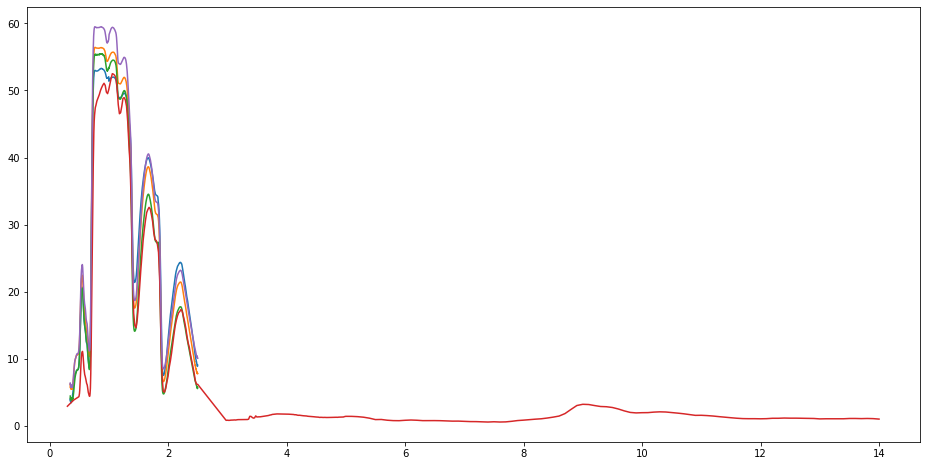

In [77]:
fig = pylab.figure()
fig.set_size_inches(16, 8)
for s in ecograss_spectra:
    pylab.plot(s.x, s.y)

In [78]:
from usgs_splib_utils import *
as_aviris_grass_spectra = [cut_range_of(np.array(s.y), np.array(s.x), 'AVIRIS') for s in ecograss_spectra]
as_aviris_grass_spectra = [interpolate_as(y, x, 'AVIRIS') / 100 for x, y in as_aviris_grass_spectra]

usgs_grass_spectrum = [SpectralData.read_from_file('grass/splib07a_Grass_dry.4+.6green_AMX27_BECKa_AREF.txt').interpolate_invalid().resample_as('AVIRIS')]

combined_grass_spectra = as_aviris_grass_spectra + usgs_grass_spectrum


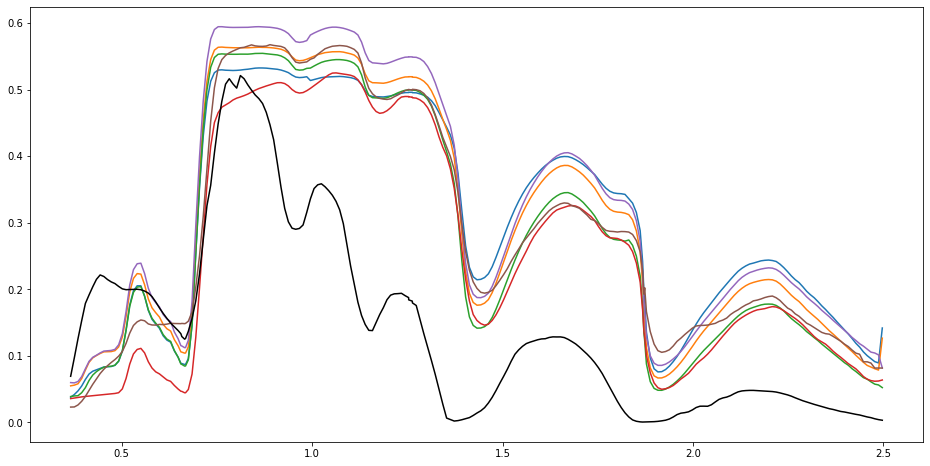

In [79]:
fig = pylab.figure()
fig.set_size_inches(16, 8)
for y in combined_grass_spectra:
    pylab.plot(wavelengths_um, y)

pylab.plot(wavelengths_um, interesting_reflectances[0], color='black')

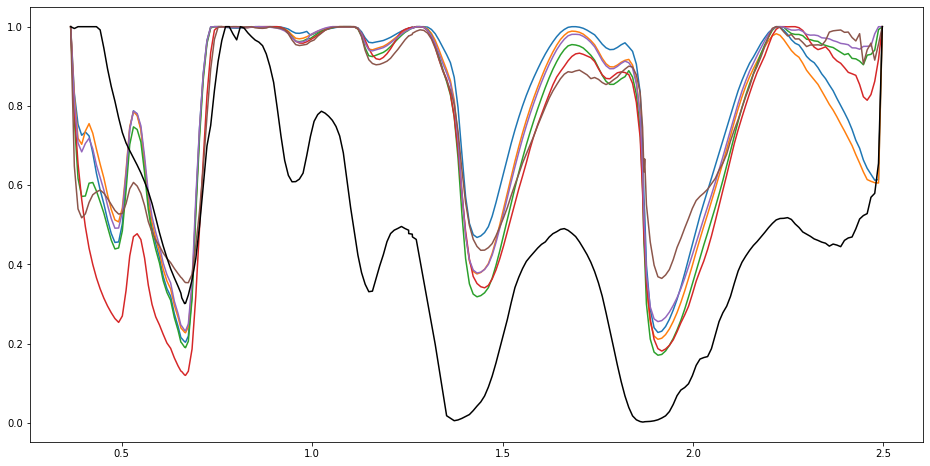

In [80]:
from spectral.algorithms.continuum import remove_continuum
fig = pylab.figure()
fig.set_size_inches(16, 8)
for y in combined_grass_spectra:
    pylab.plot(wavelengths_um, remove_continuum(y, wavelengths_um, mode='convex'))

pylab.plot(wavelengths_um, remove_continuum(interesting_reflectances[0], wavelengths_um, mode='convex'), color='black')

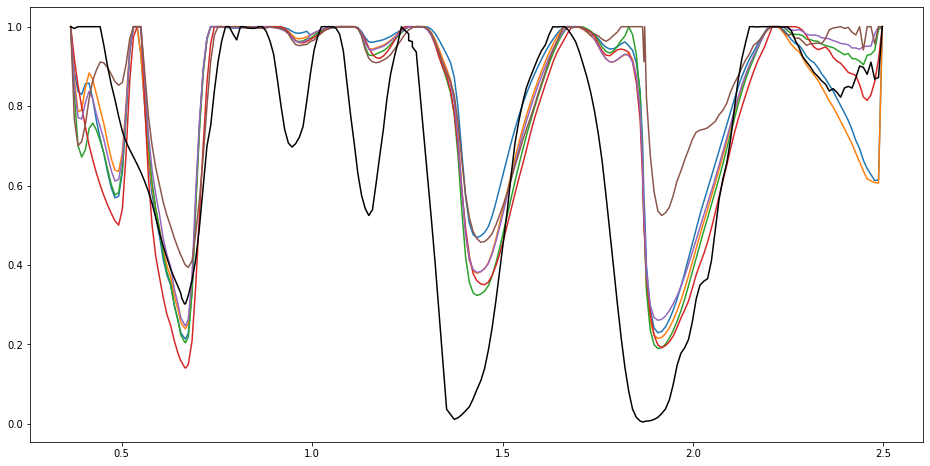

In [81]:
from spectral.algorithms.continuum import remove_continuum
fig = pylab.figure()
fig.set_size_inches(16, 8)
for y in combined_grass_spectra:
    pylab.plot(wavelengths_um, remove_continuum(y, wavelengths_um, mode='segmented'))

pylab.plot(wavelengths_um, remove_continuum(interesting_reflectances[0], wavelengths_um, mode='segmented'), color='black')

Наблюдаем влияние атмосферы и солнечного сияния на отражательную способность. Это надо как-то корректировать.

In [102]:
from utils import filter_out_of_range_spectra
spectra = filter_out_of_range_spectra(data, 0, 10000)

In [103]:
avg = np.average(spectra, axis=0)
maxes = np.max(spectra, axis=0)
from math_utils import find_max_diff_l2, find_max_diff_l1, find_max_diff_angle, find_with_max_norm2, find_with_max_norm1
max_diff_l2 = find_max_diff_l2(spectra, avg)
max_diff_l1 = find_max_diff_l1(spectra, avg)
max_diff_angle = find_max_diff_angle(spectra, avg)
max_norm2 = find_with_max_norm2(spectra)
max_norm1 = find_with_max_norm1(spectra)

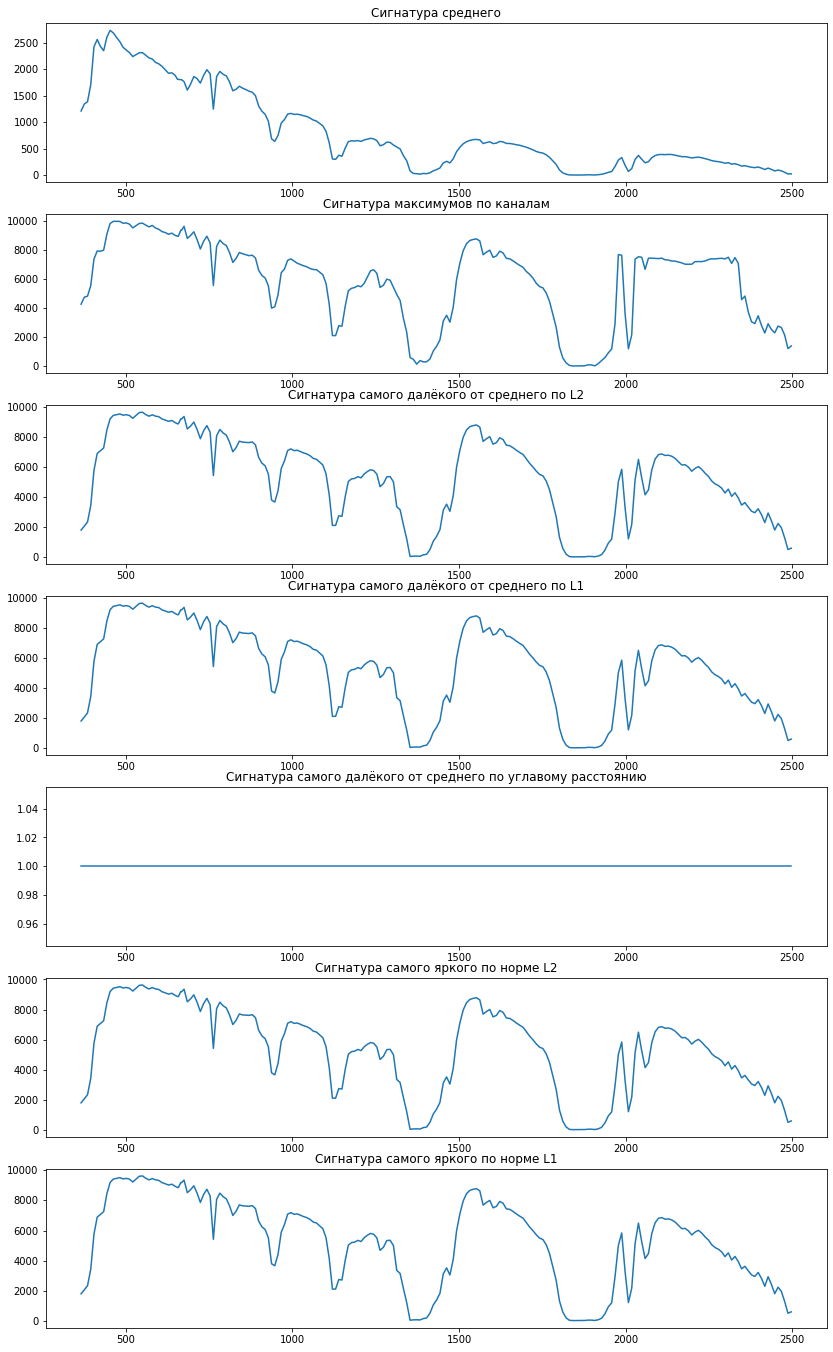

In [106]:
figs = [
    {
     'title': 'Сигнатура среднего',
     'sig': avg
    },
    {
     'title': 'Сигнатура максимумов по каналам',
     'sig': maxes
    },
    {
     'title': 'Сигнатура самого далёкого от среднего по L2',
     'sig': max_diff_l2
    },
    {
     'title': 'Сигнатура самого далёкого от среднего по L1',
     'sig': max_diff_l1
    },
    {
     'title': 'Сигнатура самого далёкого от среднего по углавому расстоянию',
     'sig': max_diff_angle
    },
    {
     'title': 'Сигнатура самого яркого по норме L2',
     'sig': max_norm2
    },
    {
     'title': 'Сигнатура самого яркого по норме L1',
     'sig': max_norm1
    }
]


fig = pylab.figure()
fig.set_size_inches(len(figs)*2, 24)

for i in range(len(figs)):
    ax = pylab.subplot(len(figs), 1, i+1)
    ax.set_title(figs[i]['title'])
    pylab.plot(wavelengths, figs[i]['sig'])

pylab.show()